<a href="https://colab.research.google.com/github/AbhishekHosmani/ExploringML/blob/master/NLP_Stance_Detection_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stance Classification of Tweets using Transfer Learning
This notebook shows how *transfer learning*, an extension of deep learning, can be used for predicting Tweet stance toward a particular topic.

# 2. Approach
This section describes the 3-Layer LSTM architecture used for transfer learning, **ULMFit**. This is the architecture described in the well known paper by [Howard and Ruder, 2018](https://arxiv.org/pdf/1801.06146.pdf), that has been proven to generalize
well to unseen distributions. The goal is to see how *ULMFit* can perform in this particular Tweet stance classification task.


## 2.1 ULMFit Model Architecture
![title](/content/sample_data/assets/ulmfit_arch.png)

Source: [Howard and Ruder, 2018](https://arxiv.org/pdf/1801.06146.pdf)

To classify out-of-domain data (such as our Twitter data), the following techniques are applied from the ULMFit paper:

### Discriminative Fine-tuning
From the *ULMFit* paper, each layer of the model captures *different types of information*. Hence, it makes sense to fine-tune each layer differently, and this is done in *ULMFit* after extensive empirical testing and implementation updates. Rather than change each layer manually, we can use the implemented ratios, but adapt the multiplier that influences the learning rate for each layer. 

*ULMFit* also uses discriminative fine-tuning with regard to the SGD update as follows:

$\theta_{t}^{l} = \theta_{t-1}^{l} - \eta^{l} \cdot \nabla_{\theta^l} J{\theta} $

### 1-cycle learning rate policy
In the fine-tuning stage, a *1-cycle learning rate* policy is applied, which comes from this [report by Leslie Smith](https://arxiv.org/abs/1803.09820). It is a modification of the cyclical learning rate policy, which has been around for a long time, but the 1-cycle policy allows a large initial learning rate ($LR_{max}=10^{-3}$, for example), but decreases it by several orders of magnitude just at the last epoch. This seems to provide greater final accuracy. In the ULMFit implementation,  this 1-cycle policy has been tweaked and is referred to as *slanted triangular learning rate*.

### Gradual unfreezing
Rather than training all the layers at once during classification, the layers are "frozen" and the last layer is fine-tuned first, followed by the next layer before it, and so on. This avoids the phenomenon known as *catastrophic forgetting* (by fine-tuning all layers too aggressively). 

### Concatenated pooling
Because an input text can consist of hundreds or thousands of words, information might get lost if we only consider the last hidden state.

Hence, the hidden state at the last time step, $h_T$ is concatenated with *both* the max-pooled and mean-pooled representation of the hidden states over as many time steps as can fit in GPU memory.

$h_C = [h_T, maxpool(H), meanpool(H)]$

Where $H$ is the vector of all hidden states.

### 3-stage fine-tuning methodology
The classification task is done in a 3-stage process:
1. General-domain LM pretraining: ULMFit has a pretrained model generated using an AWD-LSTM (as per [Merity et al., 2017]((https://arxiv.org/pdf/1708.02182.pdf))) to develop a language model called ```Wikitext-103``` and was trained of 28,595 preprocessed Wikipedia articles, totalling to 103 million words. 
2. Target task *LM* fine-tuning: Since the data for the target will likely come from a different distribution, ULMFit allows us to use the pre-trained language model anf fine-tune it (using the above techniques) to adapt to the idiosyncrasies of the target data.
3. Target task *classifier* fine-tuning: Once we save the updated weights from the language model fine-tuning step, we can fine-tune the classifier with gradual unfreezing and the other techniques described above to perform  task-specific class prediction. 


# 3. Data



## Size of dataset
The total number of Tweets (in the training set) available for this task is roughly 200, which amounts to roughly 500-600 Tweets per topic. Thus, this can be considered a small dataset. 

![title](/content/sample_data/assets/stance_balance.png)

Upon inspecting the training data, it is clear that there is quite a large variance in terms of the number of Tweets in favor vs. those against a topic. There is quite a large variance *within* classes as well as *between* classes in the overall data. 

## 3.1 Pretrained language models

*ULMFit* uses its own pretrained language model ```wikitext-103``` that can be conveniently downloaded  from the ```fastai``` database hosted on AWS. 


## 3.2 Preprocess training data
This section discusses the steps used to prepare the data for transfer learning utilizing the ```fastai``` framework. In particular, the ```fastai.text``` library is designed to work very well with tabular data, hence, Pandas DataFrames are used to organize and filter the data.

In [5]:
#@title
from fastai import *
from fastai.text import *
from pathlib import Path
import pandas as pd
import numpy as np
import re

In [40]:
#@title
path = Path('/content')
trainfile = 'inputfile.txt'
testfile = 'test_x1.txt'

Some of the characters in the training set are not *utf-8* encoded, hence we make sure that we only treat the characters that appear in the English language for this task.

In [41]:
#@title
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

In [42]:
#@title
train_orig = pd.read_csv('final_training_test.csv', header=0, encoding = "latin-1")
print(train_orig.columns)

Index(['Unnamed: 0', 'id', 'm_id', 'Stance', 'Tweet', 'emotion', 'Target'], dtype='object')


In [43]:
#@title
# Check that the latest 1.0.0 build of PyTorch has been installed 
# alongside fastai
import torch
print("Cuda available" if torch.cuda.is_available() is True else "CPU")
print("PyTorch version: ", torch.__version__)

Cuda available
PyTorch version:  1.8.1+cu101


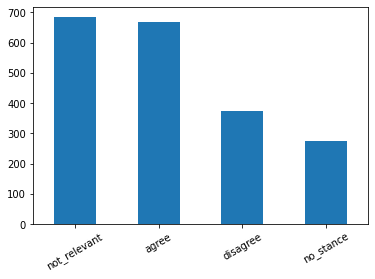

In [44]:
#@title
# Plot value counts for rach stance in the dataset
train_orig['Stance'].value_counts().plot.bar(rot=30);

In [45]:
#@title

for item in train_orig['Target'].unique():
    print(item)

More people will die as a result of a negative side effect to the COVID-19 vaccine than would actually die from the coronavirus.
The COVID-19 vaccine causes infertility or miscarriages in women.
The COVID-19 vaccine causes Bell's palsy.
Natural COVID-19 immunity is better than immunity derived from a COVID-19 vaccine.
RNA alters a person's DNA when taking the COVID-19 vaccine.
There are severe side effects of the COVID-19 vaccines, worse than having the virus.
The COVID-19 vaccine was developed to control the general population either through microchip tracking or nanotransducers in our brains.
The COVID-19 vaccine contains tissue from aborted fetuses.


### Apply the cleaning function to the 'Tweet' column of the training data

In [46]:
#@title
train_orig['Tweet'] = train_orig['Tweet'].apply(clean_ascii)

In [47]:
#@title
train_orig['Tweet'] = train_orig['emotion'] + ' - ' + train_orig['Tweet']
train_orig.head()

,Unnamed: 0,id,m_id,Stance,Tweet,emotion,Target
0,0,1340015106206392321,9,agree,anger - @meetnpatatas @RealMattCouch @Progress...,anger,More people will die as a result of a negative...
1,1,1340570906662322176,2,agree,anger - @armyveteran13 I said when the virus w...,anger,The COVID-19 vaccine causes infertility or mis...
2,2,1344724371865182208,2,agree,anger - Bombshell Interview With Del Bigtree: ...,anger,The COVID-19 vaccine causes infertility or mis...
3,3,1345709249469546496,4,agree,"anger - YOLO- berichtgeving: \n\n""COVID Vaccin...",anger,The COVID-19 vaccine causes Bell's palsy.
4,4,1344586458791723008,3,no_stance,"anger - @FatEmperor Natural immunity, I build ...",anger,Natural COVID-19 immunity is better than immun...


### Store the relevant information from training data 
ULMFit requires just the stance and the text data (i.e. tweets) for the language-model finetuning and classification steps, hence these are stored in a DataFrame.

In [48]:
#@title
train = pd.concat([train_orig['Stance'], train_orig['Tweet'], train_orig['emotion']], axis=1)
train.tail()

,Stance,Tweet,emotion
1995,not_relevant,fear - If the coronavirus vaccine doesn't caus...,fear
1996,not_relevant,fear - If the coronavirus vaccine doesn't caus...,fear
1997,agree,joy - I'm more concerned with the side effects...,joy
1998,agree,joy - I'm more concerned with the side effects...,joy
1999,agree,anger - Covid vaccine giving ppl of color Bell...,anger


In [81]:
#@title
# Write train to csv
train.to_csv(path/'train.csv', index=False, header=False)
print(train.head())

      Stance                                              Tweet emotion
0      agree  anger - @meetnpatatas @RealMattCouch @Progress...   anger
1      agree  anger - @armyveteran13 I said when the virus w...   anger
2      agree  anger - Bombshell Interview With Del Bigtree: ...   anger
3      agree  anger - YOLO- berichtgeving: \n\n"COVID Vaccin...   anger
4  no_stance  anger - @FatEmperor Natural immunity, I build ...   anger


# 5. Transfer Learning Stages

This notebook utilizes the refactored and updated version (```v1```) of *ULMFit* as implemented in the [fastai](https://github.com/fastai/fastai/tree/master/fastai)  GitHub repository. This requires an install of **Pytorch 1.0.0** ([released on December 7, 2018](https://developers.facebook.com/blog/post/2018/05/02/announcing-pytorch-1.0-for-research-production/)) to run since its development intended to move alongside PyTorch's own development cycle in the future. It is recommended to run this entire notebook in a virtual environment to avoid clashes with pre-existing installs of PyTorch.

The refactored code for *ULMFit* is much more high-level and abstracted than the original version that was used in the paper, so it doesn't make sense to rewrite the data manipulation code for text handling and tokenization from the ground up. We can take advantage of the powerful transfer learning functionality that is baked into ULMFit (obtained after months of fine-tuning and refactoring the source code by Fast.ai) instead! 

### Preprocess data for language model fine-tuning
The ```TextLMDataBunch```[ [source]](https://docs.fast.ai/text.data.html#TextLMDataBunch) class returns a "Databunch" type of object that is a custom object defined in fastai.text's API. Note that according to this class definition, a significant amount of data pre-processing is going on under the hood. 

- Initialize the language model with the pre-trained vocabulary's weights
- Create a custom data loader that "batchifies" the target task's vocabulary, i.e. split it up into batches for processing on the GPU
- Introduce randomness into the batches, but without breaking up the sentence sequences using techniques [borrowed from language modeling](https://arxiv.org/pdf/1708.02182.pdf).
- Tokenize the target task's vocabulary and increase the efficiency of tokenization (for large tasks) using multi-threading
 

In [96]:

#@title
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', label_cols='Stance', min_freq=1)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


Note that in this case, we specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag ```<unk>``` during tokenization.

In [97]:
#@title
# Save the language and classifier model data for re-use
data_lm.save()

In [98]:
#@title
data_lm.show_batch()

idx,text
0,"xxmaj jab xxmaj caused xxmaj it xxup url xxbos anger - xxup cnbc - xxmaj if you get severe xxmaj covid vaccine side effects , there 's likely no one to sue xxup @cnbc xxup url : "" xxmaj you ca n't sue xxmaj pfizer or xxmaj moderna if you have severe xxmaj covid vaccine side effects . xxmaj the government likely wo n't compensate you for damages either """
1,"xxmaj to put everyone on lock down indefinitely to have you dependent on the government . xxbos fear - xxmaj people would rather die from covid than get the vaccine xxup lmaooo real smart xxbos sadness - i will not take a covid vaccine . xxbos sadness - xxmaj clear and present danger . xxup url xxup qt : "" xxup attention \n xxmaj the xxmaj covid 19 vaccine"
2,"have we seen the xxup technology used in this proposed upcoming xxmaj covid-19 vaccine . xxmaj it uses a xxup modified xxup rna or a modified xxup dna in the vaccine . xxup nb : it could alter our xxup dna / xxup rna / genome these are what make us xxup human , separating us from plants and animals . xxbos anger - xxmaj luciferase is part of the"
3,"younger than 65 , it 's much more likely i 'm going to get sick from the vaccine than die xxup or get more benefit from a vaccine . xxbos joy - xxmaj will the people who died from the xxup covid vaccine be classified as a xxup covid death ? xxmaj just asking . xxup url xxbos fear - * xxmaj warning * \n the xxmaj covid vaccine"
4,"the xxup covid-19 vaccine include being xxmaj marco xxmaj rubio . xxbos anger - xxmaj why is # xxmaj marr hiding the truth ? \n \n xxmaj the # covidvaccine 's do n't work , have xxup not been safety tested & & come with severe risks of adverse side effects \n \n xxmaj several cheap & & effective treatments are available so vaccines are completely unnecessary \n"


We only need to run the above tokenization step once, and save the data. All the data goes to a local folder named ```tmp/```. For a large added vocabulary, the above tokenization step can take a while, hence we save them and restart the notebook from the next cell (if we close our session).

The tokenization technique used by ```fastai.text``` is quite advanced, and uses quite a few tricks to capture semantic meaning from the text. Unlike typical NLTK-type tokenization, here we are not converting the Tweets to lowercase and removing information from the base text - that would result in a tremendous loss of information that our model could use to gather an understanding of our new task's vocabulary.

Instead, a number of added tokens are applied so that minimal information is lost. A full list of all the tokenization rules used are [here](https://docs.fast.ai/text.transform.html#Rules). 

As an example, the ```xxmaj``` token [[source]](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/transform.py#L71) indicates that there is capitalization of the word, either in part or in full. "The" will be tokenized as "xxmaj the". For words that are full capitalized, such as "I AM SHOUTING"; it is tokenized as "xxup i xxup am xxup shouting". The tokenizer uses spaCy's underlying tokens, but adds tags in a very smart way that balances capturing semantic meaning while reducing the number of overall tokens, so it is both powerful and efficient. 

The tokenization process described above is highly efficient, in part thanks to the power of *SpaCy* and also due to the multi-threading wrappers implemented by Fast.ai on top of Spacy's tokenizer. As a result, a really large language model's vocabulary (of millions of words) can also be effectively tokenized in a reasonable time. 

### Define learner object for language model finetuning
We define a learner object that uses the tokenized language model data, that is organized into batches for the GPU, and feed it a pre-trained language model. 

We use the ```wt_103_v1``` model that was refined after re-training using the more efficient ```fastai v1``` library. The data (```lstm_wt103.pth```) is downloaded through an AWS-hosted link (accessed through the ```fastai.datasets``` interface), and stored locally. All the data in the language model file is numericalized and stored in a way that the learner can efficiently pick up tokens in float form. In addition to the language model, there is also an additional pickle object ```itos_wt103.pkl``` that is similar to the ```torchtext``` definition of "integer-to-string" - this contains the list of unique tokens in word form, so that we can map the tokens back to strings if necessary.

In [99]:
#@title
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

### Print the structure of the language model RNN 
We can examine the architecture of the 3-layer LSTM used in ULMFit as shown below. For the language model fine-tuning, we define the embeddings based on the the target task vocabulary size. A single linear output layer is defined  that updates the weights once we pass the input through the network.

In [100]:
#@title
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(4680, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(4680, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=4680, bias=True)
   (output_dp): RNNDropout()
 )]

### Find the optimum learning rate 
```fastai.train``` [source](https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23) provides a convenient utility to search through a range of learning rates to find the optimum one for our dataset. 

The idea is that our optimization function needs to use a learning rate that is an order of magnitude below the point at which the loss starts to diverge. We can quickly find this as shown below. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


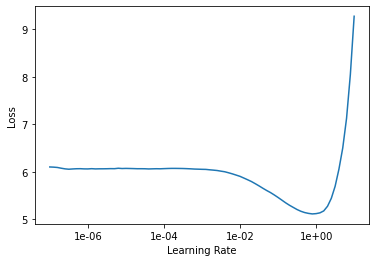

In [101]:
#@title
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

### Run the ```language_model_learner``` class
The pre-trained language model quickly downloads from the ```fastai```'s AWS link, so there is no need to download it separately. [```drop_mult```] is the multiplier applied to the dropout in the language learner. As per the ULMFit paper, we use a custom dropout for each language model layer, and the ```drop_mult```just scales a [numpy array of these dropouts](https://github.com/fastai/fastai/blob/1c5c007e10a187f4a048a3ee8137016534259768/fastai/text/learner.py#L15) which remain in the same relative ratio to one another. These numbers have been obtained through empirical tuning for a range of language tasks, and we took note of this during our extensive reading on this task.

In [102]:
#@title
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)
learn.fit_one_cycle(cyc_len=100, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.067759,5.738443,0.187891,00:05
1,6.058726,5.717596,0.188504,00:05
2,6.039986,5.691931,0.189230,00:05
3,6.020428,5.653055,0.190513,00:05
4,5.993806,5.607065,0.190458,00:05
5,5.960014,5.551341,0.192801,00:05
6,5.919260,5.484348,0.195257,00:05
7,5.867901,5.399844,0.199051,00:05
8,5.801802,5.303904,0.200670,00:05
9,5.729197,5.193451,0.206083,00:05


### Unfreeze the entire model 
To train the language model during fine-tuning, we unfreeze all the layers and then perform training for a reasonable time until we obtain a low enough validation loss. For a larger target vocabulary, these hyperparameters might need to be modified, and teh training time would be significantly longer

In [103]:
#@title
learn.unfreeze()
learn.fit_one_cycle(cyc_len=100, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.535183,3.150222,0.421150,00:06
1,1.503487,3.150885,0.423214,00:06
2,1.471083,3.150119,0.425837,00:06
3,1.438989,3.158029,0.428237,00:06
4,1.409767,3.167246,0.430692,00:06
5,1.373906,3.172922,0.434375,00:06
6,1.330964,3.184325,0.437612,00:06
7,1.280173,3.186979,0.438895,00:06
8,1.227272,3.203314,0.444531,00:06
9,1.172848,3.256197,0.446261,00:06


In [105]:
#@title
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

## 5.2 Train the Classifier

### Specify the topic we want to classify for
We specify the topic name exactly as the training data does, and use it to subset the Pandas DataFrame.

In [106]:
#@title
# Write train to csv
train.to_csv(path/'train1.csv', index=False, header=False)

### Create classification dataloader
For classification, the ```TextClasDataBunch```  [[source](https://docs.fast.ai/text.data.html#TextClasDataBunch)] dataloader used is slightly different. Just like the language model custom data loader described in the previous section, it does a lot under the hood. The classification data loader tokenizes the training data, but batchifies the data differently from the language model data loader - for classification, we perform sorting so as to group all large sentences together, and smaller sentences together - and pad them to have all batches of roughly the same length, followed by randomizing these batches so that we don't introduce additional bias during training.

Just like before, we define the learner object used for classification. Note that we feed in the entire vocabulary of the training data to the classifier. We once more specify a minimum word frequency of 1 (i.e. words that appear just once in the data are given the tag ```<unk>```.

In [107]:

# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'train1.csv', vocab=data_lm.train_ds.vocab,min_freq=1, bs=32)
data_clas.save()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [108]:
learn = text_classifier_learner(data_clas,AWD_LSTM,drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

Note that we begin the training with all the outer layers as frozen. The fine-tuned language model is read in, and we use a dropout multiplier as shown above. 

For training the classifier, we apply "gradual unfreezing", to avoid "catastrophic forgetting" as explained in section $3.3$ of [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf). In addition to gradual unfreezing, 

### Just as before, find optimum learning rate for the classifier

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


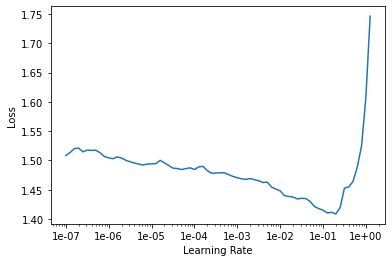

In [109]:

learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

### Carefully train the classifier
During classification, we gradually unfreeze layers as shown below. This helps us obtain a better classification accuracy than if we were to aggressively train all the layers at once. 

In [110]:
#@title
learn.fit_one_cycle(cyc_len=100, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.466860,1.318676,0.385000,00:05
1,1.457067,1.293281,0.425000,00:04
2,1.420211,1.271321,0.447500,00:05
3,1.390394,1.256995,0.445000,00:04
4,1.371924,1.249710,0.435000,00:04
5,1.335005,1.216808,0.482500,00:04
6,1.304019,1.208492,0.492500,00:04
7,1.286812,1.194199,0.492500,00:05
8,1.266839,1.160031,0.522500,00:04
9,1.241174,1.164497,0.502500,00:04


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [111]:
# #@title
learn.freeze_to(-2)
learn.fit_one_cycle(100, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.771357,1.212698,0.527500,00:05
1,0.762190,1.211490,0.540000,00:05
2,0.743759,1.244252,0.527500,00:05
3,0.760446,1.250835,0.515000,00:05
4,0.720692,1.269937,0.560000,00:05
5,0.735043,1.306553,0.562500,00:05
6,0.724185,1.279303,0.572500,00:05
7,0.713155,1.276480,0.542500,00:05
8,0.763353,1.314573,0.515000,00:06
9,0.786375,1.285028,0.562500,00:05


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [112]:
# #@title
learn.freeze_to(-3)
learn.fit_one_cycle(100, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.125219,2.699589,0.565000,00:08
1,0.132965,2.611511,0.570000,00:07
2,0.139632,2.624735,0.585000,00:08
3,0.158162,2.659989,0.567500,00:09
4,0.155522,2.665293,0.575000,00:08
5,0.146889,2.633429,0.567500,00:08
6,0.155532,2.673894,0.565000,00:08
7,0.135182,2.675066,0.565000,00:07
8,0.139126,2.672738,0.575000,00:09
9,0.139212,2.676594,0.572500,00:09


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [113]:
#@title
learn.unfreeze()
learn.fit_one_cycle(100, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.099275,3.042257,0.585000,00:11
1,0.101517,2.905262,0.597500,00:09
2,0.104556,3.112176,0.595000,00:09
3,0.109684,3.016242,0.580000,00:09
4,0.112479,3.057582,0.577500,00:10
5,0.102056,2.983202,0.582500,00:10
6,0.105106,3.003587,0.582500,00:09
7,0.114023,3.106182,0.585000,00:10
8,0.108969,3.117820,0.585000,00:10
9,0.103818,3.028911,0.587500,00:11


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

### Cross-tabulate the predictions for each class
The below table shows the predicted classes for the topic in concern. The actual evaluation of the F1 score of the classification result is done at a later step.

In [115]:
#@title
# get predictions
# meta_input = Input(shape=(10,), name='meta_input')
# x = concatenate([learn, meta_emo_input])
# x = Dense(classifier_neurons, activation='relu')(x)
# x = Dense(1, activation='sigmoid')(x)
# model = Model(inputs=[nlp_input , meta_input], outputs=[x])

preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)

pd.crosstab(predictions, targets)

col_0,0,1,2,3
row_0,,,,
0,94,7,19,26
1,13,37,9,6
2,8,5,21,11
3,31,12,19,82


In [116]:
# print(predictions)

## Evaluate the predicted results from the classifier 
We read in the test dataset and store in a Pandas DataFrame as shown.

In [117]:
#@title
test = pd.read_csv(path/testfile, delimiter='\t', header=0, encoding = "latin-1")
test = test.drop(['ID'], axis=1)
# test['Tweet'] = test['Tweet'].apply(clean_ascii)
test.head()

,Target,Tweet,Stance
0,There are severe side effects of the COVID-19 ...,"Just so y'all know, it's possible that the vac...",UNKNOWN
1,Natural COVID-19 immunity is better than immun...,@JCope222 Vaccine is untested for safety. Peop...,UNKNOWN
2,Natural COVID-19 immunity is better than immun...,@catturd2 Why would antibodies formed from rec...,UNKNOWN
3,There are severe side effects of the COVID-19 ...,I started thinking about the long term effects...,UNKNOWN
4,Natural COVID-19 immunity is better than immun...,I like vaccine herd immunity over infection he...,UNKNOWN


Since we do not yet know the stance for the test set, it is marked as "UNKNOWN". 

### Filter the test data set based on topic we are classifying for

In [118]:
#@title
test_pred = test[['Target', 'Tweet']]
# test_pred = test_pred.loc[test_pred['Target'] == topic]
test_pred.tail()


,Target,Tweet
1206,The COVID-19 vaccine causes infertility or mis...,"@talkRADIO @PatrickChristys URL: ""Information ..."
1207,The COVID-19 vaccine causes infertility or mis...,COVID Vaccine Could Make The Virus Far More De...
1208,The COVID-19 vaccine causes Bell's palsy.,At least four individuals contracted Bell's Pa...
1209,RNA alters a person's DNA when taking the COVI...,And RNA changes your DNA. Do not take the vacc...
1210,The COVID-19 vaccine causes infertility or mis...,Covid vaccine is Not safe it changes our genes...


In [119]:
# print(learn.predict("@WillWinWon @mynameisjerm BILL GATES Admits Covid Vaccine ALTERS DNA URL")[0])

### Apply the learner's ```predict``` method to produce our prediction

In [120]:
#@title
test_pred['Stance'] = test_pred['Tweet'].apply(lambda row: str(learn.predict(row)[0]))

In [121]:
#@title
test_pred.tail()

,Target,Tweet,Stance
1206,The COVID-19 vaccine causes infertility or mis...,"@talkRADIO @PatrickChristys URL: ""Information ...",disagree
1207,The COVID-19 vaccine causes infertility or mis...,COVID Vaccine Could Make The Virus Far More De...,agree
1208,The COVID-19 vaccine causes Bell's palsy.,At least four individuals contracted Bell's Pa...,disagree
1209,RNA alters a person's DNA when taking the COVI...,And RNA changes your DNA. Do not take the vacc...,agree
1210,The COVID-19 vaccine causes infertility or mis...,Covid vaccine is Not safe it changes our genes...,agree


### Output the predicted dataset to a text file for comparison with the gold reference

In [76]:
#@title
test_pred.to_csv('/content/abhishek_predicted_v1.txt', sep='\t', index=True,
                 header=['Target', 'Tweet', 'Stance'], index_label='ID')